<a href="https://colab.research.google.com/github/kaleetock/clusters/blob/main/Ref_Stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Installs and Imports
%%capture
!pip install astropy
!pip install astroquery
import astroquery.gaia
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
from astropy.coordinates import Angle
from astroquery.gaia import Gaia
from google.colab import drive
from astroquery.vizier import Vizier
import math
import bokeh.plotting as bk
import matplotlib as mpl
from bokeh.models import Range1d, Label
from bokeh.models import Title
from bokeh.layouts import row, gridplot
import numpy as np
import os
import re
import json
import requests

from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
from astropy.wcs import WCS

name_dict = {
6: "ASASSN-V J101726.09-462702.3",
10: "NGC 3201 V10",
12: "ASASSN-V J101729.03-462255.8",
14: "WISE J101722.4-462231",
15: "NSV 4813",
16: "ASASSN-V J101718.47-462836.5",
19: "ASASSN-V J101739.47-461930.8",
20: "ASASSN-V J101741.03-462003.3",
21: "NGC 3201 V021",
24: "ASASSN-V J101704.92-462425.2",
25: "ASASSN-V J101746.15-462152.1",
26: "ASASSN-V J101758.09-462701.8",
27: "ASASSN-V J101742.79-463001.0",
29: "ASASSN-V J101712.92-462249.6",
30: "NGC 3201 V30",
31: "ASASSN-V J101754.54-462234.1",
32: "ASASSN-V J101755.79-462126.7",
34: "ASASSN-V J101805.48-462002.2",
41: "ASASSN-V J101805.02-462414.8",
42: "NGC 3201 V42",
46: "1SWASP J101657.56-463212.1",
47: "ASASSN-V J101747.56-462041.7",
49: "ASASSN-V J101733.63-462213.4",
53: "1SWASP J101613.07-463701.0",
54: "ASASSN-V J101841.68-463753.6",
55: "1SWASP J101705.37-461159.9",
56: "ASASSN-V J101800.45-462309.3",
57: "ASASSN-V J101804.87-462554.6",
58: "ASASSN-V J101810.58-462604.6",
59: "1SWASP J101651.71-462523.2",
60: "ASASSN-V J101615.55-462316.1",
61: "1SWASP J101550.94-462115.7",
64: "1SWASP J101635.75-461031.4",
65: "KP Vel",
67: "ASASSN-V J101700.89-462635.3",
68: "NSV 4810",
69: "1SWASP J101716.28-460810.8",
73: "ASASSN-V J101725.20-462315.1",
84: "ASASSN-V J101811.71-461306.4",
87: "1SWASP J101912.42-463238.7",
89: "ASASSN-V J101953.63-462759.8",
91: "ASASSN-V J101511.31-460443.3",
93: "1SWASP J102052.70-462708.6",
94: "ASAS J101302-4553.7",
96: "ASASSN-V J101305.15-463203.3"
}


drive.mount("/content/drive")



In [4]:
#@title Functions to build data structure
########################################################

def parse_filename(pf):
  m = re.search( r'(([a-zA-Z0-9]+)_([aBVirpguzsw]+)_(\d+)d(\d+)_(\d\d\d\dd\d\dd\d\d)T\d\dd\d\dd\d\dd\d\d\d_(\d)a([\d]+)_(\d+)d(\d+)_(kb[0-9]+)[_\w]+)\.', pf )  

  if m:
    file_prefix = m.group(1)
    target = m.group(2)
    filter_color = m.group(3)
    bjd_timestamp = float(m.group(4)+"."+m.group(5))
    date = m.group(6)
    airmass = float(m.group(7)+"."+m.group(8))
    exposure_time = float(m.group(9)+"."+m.group(10))
    telescope = m.group(11)

    m2 = re.search( r'(.*?)MEDSTACK$', target)
    if m2:
      target = m2.group(1)

    return(target, filter_color, bjd_timestamp, date, airmass, exposure_time, telescope)

  else:
    print(f"Could not parse filename {pf}!")

########################################################

def get_gaia_edr3_stars_within_search_box (ra_deg, dec_deg, search_box_deg, mag_limit, target):  
  print("Querying stars less than mag %.0f around coords of %s (%.5f, %.5f) in Gaia EDR3; search box of *side* %.1f deg." % (mag_limit, target, ra_deg, dec_deg, search_box_deg))
  Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"
  Gaia.ROW_LIMIT = -1
  coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
  width = u.Quantity(search_box_deg, u.deg)
  height = u.Quantity(search_box_deg, u.deg)
  r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

  gstars, starcount, num_Gaia, ras, decs, epochs = {}, 0, 0, [], [], []
  for star in r:
    ra, dec, plx, pmra, pmdec, gmag, bp_rp, rv, epoch = star['ra'], star['dec'], star['parallax'], star['pmra'], star['pmdec'], star['phot_g_mean_mag'], star['bp_rp'], star['dr2_radial_velocity'], star['ref_epoch']
    num_Gaia += 1

    ra = float(ra)
    dec = float(dec)
    plx = float(plx)
    pmra = float(pmra)
    pmdec = float(pmdec)
    gmag = float(gmag)
    bp_rp = float(bp_rp)
    rv = float(rv)
    epoch = float(epoch)

    if gmag > mag_limit:
      continue

    ras.append(ra)
    decs.append(dec)
    epochs.append(epoch)
    starcount += 1
    k = str("%.1f,%.1f" % (ra, dec))
    if not k in gstars.keys():
      gstars[k] = []
    gstars[k].append({"id": str("%.6f,%.6f" % (ra, dec)), "ra": float(ra), "dec": float(dec), "plx": plx, "pmra": pmra, "pmdec": pmdec, "gmag": float(gmag), "bp_rp": bp_rp, "rv": rv})

  print(f"Searched a box of SIDE {search_box_deg} deg around {str('%.3f' % ra_deg)}, {str('%.3f' % dec_deg)}.")
  print(f"{num_Gaia} stars in Gaia EDR3; {starcount} below mag {mag_limit}.")
  print(f"RAs from {str('%.3f' % min(ras))} to {str('%.3f' % max(ras))}, Decs from {str('%.3f' % min(decs))} to {str('%.3f' % max(decs))}")
  gstars_region = {"minra": min(ras), "maxra": max(ras), "mindec": min(decs), "maxdec": max(decs)}
  return(gstars, epochs[0])  # Assume all epochs are the same.

##########################################################

def get_APASS_stars_within_search_radius(ra_deg, dec_deg, search_box_deg, mag_limit, equinox, epoch):

  print("Querying same stars in APASS; search *radius* %.1f deg.\nNote: no adjustment for epoch / equinox at this point (Gaia ref_epoch is %d)." % (search_box_deg, epoch))
  search_radius_deg = search_box_deg / 2
  v = Vizier(row_limit=-1)
  v.query = Vizier(columns=['_RAJ2000', '_DEJ2000','Bmag', 'Vmag', 'B-V', 'gpmag'])

  result = v.query_region(SkyCoord(ra=ra_deg, dec=dec_deg,unit=(u.deg, u.deg),frame='icrs'), radius=Angle(search_radius_deg, "deg"), catalog=["APASS"])

  Astars, starcount, ras, decs = {}, 0, [], []

  if "II/336/apass9" in result.keys(): 
    num_APASS = len(result["II/336/apass9"])

    for i in range (0, num_APASS):
      fr = result['II/336/apass9'][i]
      (ra, dec, ABmag, AVmag, AB_V) = (fr["RAJ2000"], fr['DEJ2000'], fr["Bmag"], fr["Vmag"], fr["B-V"])
      if AVmag > mag_limit:
        continue

      ra = float(ra)
      dec = float(dec)
      ABmag = float(ABmag)
      AVmag = float(AVmag)
      AB_V = float(AB_V)

      c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame=FK5, equinox='J2000')
#      c1 = c.transform_to(FK5(equinox=equinox))
#      ra, dec = c1.ra.deg, c1.dec.deg

      ras.append(ra)
      decs.append(dec)
      starcount += 1
      k = str("%.1f,%.1f" % (ra, dec))
      if not k in Astars.keys():
        Astars[k] = []
      Astars[k].append({"id": str("%.6f,%.6f" % (ra,dec)), "ra": float(ra), "dec": float(dec), "ABmag": ABmag, "AVmag": float(AVmag), "AB_V": AB_V })

  print(f"Searched a box of RADIUS {search_radius_deg} deg around {str('%.3f' % ra_deg)}, {str('%.3f' % dec_deg)}.")
  print(f"{num_APASS} stars in APASS 9; {starcount} below mag {mag_limit}.")
  print(f"RAs from {str('%.3f' % min(ras))} to {str('%.3f' % max(ras))}, Decs from {str('%.3f' % min(decs))} to {str('%.3f' % max(decs))}")
  return(Astars, {"minra": min(ras), "maxra": max(ras), "mindec": min(decs), "maxdec": max(decs)})

##########################################################

def make_star(coord_src, pulsator, s):
  star = {"coord_src": coord_src, "is_known_pulsator": pulsator }
  star["stardata"] = {coord_src: s}
  star["id"] = str("%.6f,%.6f" % (s['ra'], s['dec']))
  star["phot"] = {}
  return(star)

##########################################################

def check_APASS(gstar, Astars, region, distance_threshhold, min_mag_diff, max_mag_diff):
  gra, gdec, gmag = gstar["ra"], gstar["dec"], gstar["gmag"]
  if not region in Astars.keys():
#    print(f"region {region} not in Astars.keys()")
    return ({}, False)
  astars = Astars[region]
  closest_dist, closest_star, in_APASS = 1000000, {}, False
  for astar in astars:
    ara, adec, amag = astar["ra"], astar["dec"], astar["AVmag"]
    dist = np.sqrt((ara-gra)**2 + (adec-gdec)**2)
    if dist < closest_dist and dist < distance_threshhold and (amag - gmag) > min_mag_diff and (amag - gmag) < max_mag_diff:
      closest_dist = dist
      closest_star = astar
      in_APASS = True
  return(closest_star, in_APASS)
  
##########################################################

def check_cluster_cat(star, cluster_catalog, distance_threshhold, max_mag_diff):
  coord_src = star["coord_src"]
  sra, sdec, smag = star["stardata"][coord_src]["ra"], star["stardata"][coord_src]["dec"], 0.0
  if "APASS" in star["stardata"].keys():
    smag = star["stardata"]["APASS"]["AVmag"]
  else:
    smag = star["stardata"]["Gaia"]["gmag"]
  closest_dist, closest_star, known_pulsator = 1000000, {}, False
  for pulsator in cluster_catalog:
    pra, pdec, pmag = pulsator["ra"], pulsator["dec"], pulsator["mag"]
    dist = np.sqrt((sra-pra)**2 + (sdec-pdec)**2)
    if dist < closest_dist and dist < distance_threshhold:
      if type(pmag) is not float or (abs(pmag-smag) < max_mag_diff):
        closest_dist = dist
        closest_star = pulsator
        known_pulsator = True
  return(closest_star, known_pulsator)

##########################################################

def match_stars(Astars, gstars, distance_threshhold, min_mag_diff, max_mag_diff, cluster_catalog):
  print(f"Matching APASS stars to Gaia (coords within {distance_threshhold} degrees, {min_mag_diff} < (APASS mag - Gaia mag) < {max_mag_diff}).")
  regions, APASS_stars_matched, pulsators_matched = {}, {}, {}
  for region in gstars.keys():
    regions[region] = {}
    for gstar in gstars[region]:
      regions[region][gstar["id"]] = make_star("Gaia", False, gstar)
      astar, in_APASS = check_APASS(gstar, Astars, region, distance_threshhold, min_mag_diff, max_mag_diff)
      if in_APASS:
        regions[region][gstar["id"]]["stardata"]["APASS"] = astar
        APASS_stars_matched[astar["id"]] = True 
      cstar, known_pulsator = check_cluster_cat(regions[region][gstar["id"]], cluster_catalog, distance_threshhold, max_mag_diff)
      if known_pulsator:
        regions[region][gstar["id"]]["stardata"]["Clements"] = cstar
        regions[region][gstar["id"]]["is_known_pulsator"] = True
        pulsators_matched[cstar["id"]] = True
      
  for region in Astars.keys():
    if region not in regions.keys():
#      print(f"Region {region} in APASS but not in Gaia!")
      regions[region] = {}
    for astar in Astars[region]:
      if astar["id"] in APASS_stars_matched.keys():
        continue
      regions[region][astar["id"]] = make_star("APASS", False, astar)
      cstar, known_pulsator = check_cluster_cat(regions[region][astar["id"]], cluster_catalog, distance_threshhold, max_mag_diff)
      if known_pulsator:
        regions[region][astar["id"]]["stardata"]["Clements"] = cstar
        regions[region][astar["id"]]["is_known_pulsator"] = True
        pulsators_matched[cstar["id"]] = True

  for cstar in cluster_catalog:
    if cstar["id"] in pulsators_matched.keys():
      continue
    region = str(f"%.1f,%.1f" % (cstar["ra"], cstar["dec"]))
    if region not in regions.keys():
      print(f"**** Problem!  Region {region} from cluster catalog not in Gaia or APASS!!")
    regions[region][cstar["id"]] = make_star("Clements", True, cstar)

  return(regions)

##########################################################

def id_ref_stars(star_counts, regions, num_files, ref_file_fraction, phot, filt, good_ref_stdev, good_ref_criterion):
  print(f"\nIdentifying ref stars that appear in {100*ref_file_fraction}% of the images, have at least {good_ref_criterion}\ncheck stars, and have a magnitude standard deviation less than {good_ref_stdev}.\n")
  potential_ref_count, prefs = 0, {}
  for ident in star_counts:
    if star_counts[ident] >= (ref_file_fraction*num_files):
      for region in regions:
        stars = regions[region]
        if ident in stars.keys():
          sd = stars[ident]["stardata"]
          if "APASS" in sd.keys() and "Gaia" in sd.keys() and not stars[ident]["is_known_pulsator"]:
            if "AVmag" in sd["APASS"].keys() and type(sd["APASS"]["AVmag"]) is float:
              if "gmag" in sd["Gaia"].keys() and type(sd["Gaia"]["gmag"]) is float:
                potential_ref_count += 1
                prefs[ident] = stars[ident]

  print(f"There are {potential_ref_count} stars with known (matched) APASS and Gaia mags that show up in \nat least {100*ref_file_fraction}% of the {phot} images in {filt} and are not known pulsators.")

  pref_keys = sorted(prefs.keys())
  ref_stdevs = {}
  for i in range(len(pref_keys)):
    for j in range(len(pref_keys)):
      if i >= j:
        continue
      key1, key2 = pref_keys[i], pref_keys[j]
      pref1, pref2 = prefs[key1], prefs[key2]
      stdev1, stdev2 = get_stdev(pref1, pref2, phot, filt)
      if stdev1 < good_ref_stdev and stdev2 < good_ref_stdev:
        if i not in ref_stdevs.keys():
          ref_stdevs[i] = []
        if j not in ref_stdevs.keys():
          ref_stdevs[j] = []
        ref_stdevs[i].append(round(stdev1,4))
        ref_stdevs[j].append(round(stdev2,4))

  good_refs, good_ref_mags = {}, {}
  for i in ref_stdevs.keys():
    ident = pref_keys[i]
    stdevs = ref_stdevs[i]
    ref = prefs[ident]
    ref_mag = ref['stardata']['APASS']['AVmag']
    num_stdevs = len(stdevs)
    ref["num_stdevs"] = num_stdevs
    ref["avg_stdev"] = round(np.mean(stdevs), 3)
    if (ref_mag > 15 and num_stdevs >= 3) or (num_stdevs >= good_ref_criterion):
      ref_data = str(f"ref mag {round(ref_mag,3)}: {num_stdevs} good comps.  stdevs {stdevs}")
      good_refs[ident] = ref
      good_ref_mags[str(ref_mag)+str(f" {ident}")] = ref_data

  for ref_mag in sorted(good_ref_mags.keys()):
    good_ref_data = good_ref_mags[ref_mag]
    print(f"{good_ref_data}")

  return(good_refs)

##########################################################

# Calibrate the two potential reference stars against *each other's* known 
# APASS V-filter mags, and then take the standard deviation.

def get_stdev(pref1, pref2, phot, filt):
  mag1 = pref1["stardata"]["APASS"]["AVmag"]
  mag2 = pref2["stardata"]["APASS"]["AVmag"]

  ts1 = pref1["phot"][phot+filt]["timeseries"]
  ts2 = pref2["phot"][phot+filt]["timeseries"]

  mags1, mags2 = [], []
  for t in sorted(ts1.keys()):
    counts1 = ts1[t]["counts"]
    if t in ts2.keys():
      counts2 = ts2[t]["counts"]
      mags1.append(mag2 - 2.5*(np.log10(counts1/counts2)))
      mags2.append(mag1 - 2.5*(np.log10(counts2/counts1)))
  
  stdev1 = np.std(mags1)
  stdev2 = np.std(mags2)

  return(stdev1, stdev2)

##########################################################

def id_stars(p, regions, distance_threshhold, phot, filt):
  print(f"There are {len(regions.keys())} 'non-sketchy' match regions containing at least one star of known magnitude.\nCounting how many {phot} {filt} files each matched star shows up in (to within {distance_threshhold} degrees).")

  fs = os.listdir(p)
  files = []
  for f in fs:
    if os.path.isfile(os.path.join(p,f)):
      files.append(f)
  files.sort(key = lambda f: os.stat(os.path.join(p,f)).st_size, reverse=True)  # Do biggest file first to ensure that we add non-catalog 
                                                              # stars to dict early so that they will be found in later files
  num_files = len(files)
  num_done = 0

  star_counts, timestamps = {}, []
  for f in files:
    (target, filter_color, bjd_timestamp, date, airmass, exposure_time, telescope) = parse_filename(f)
    num_done += 1
    with open(os.path.join(p, f)) as pf:
      for line in pf:
        (ra, dec, px, py, counts, count_err, u1, u2) = line.split(",")
        region = str("%.1f,%.1f" % (float(ra), float(dec)))
        if region in regions.keys():
          closest_dist, closest_star, closest_star_id, found_star = 100000000, {}, "", False
          for id in regions[region].keys():
            m = re.search(r"(\d+\.\d+),(-?\d+\.\d+)",id)
            star_ra, star_dec = float(m.group(1)), float(m.group(2))
            distance = np.sqrt((star_ra - float(ra))**2 + (star_dec - float(dec))**2)
            if distance < closest_dist and distance < distance_threshhold:
              closest_star, closest_dist, closest_star_id, found_star = regions[region][id], distance, id, True
          if found_star:
            if not phot+filt in closest_star["phot"].keys():
              closest_star["phot"][phot+filt] = {"image_count": 0, "phot_folder": p, 
                                                 "first_image": {"file": f, "px": float(px), "py": float(py)}, 
                                                 "ref_star": {}, "timeseries": {} }
            closest_star["phot"][phot+filt]["image_count"] += 1
            closest_star["phot"][phot+filt]["timeseries"][bjd_timestamp] = {"counts": float(counts) }
            if closest_star["id"] not in star_counts.keys():
              star_counts[closest_star_id] = 0
            star_counts[closest_star_id] += 1
          else:
            star = make_star(phot+filt, False, {"ra": float(ra), "dec": float(dec)} )
        else:
          print(f"*** PROBLEM: region {region} from images is not in known star regions!")

    if (num_done%10 == 0):        
      print(f"{num_done} of {num_files} files checked for Gaia stars.")

  return(star_counts, num_files)

##########################################################

def show_best_ref_stars (good_refs, InputFITS, phot, filt):
  print(f"\n{len(good_refs.keys())} good reference stars found in {phot} phot {filt} filter!  Displaying them below.")

  infits = fits.open(InputFITS)
  image_data = infits[0].data
  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
  fig = plt.figure(figsize=(9,6))
  ax = fig.add_subplot(111)
  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)
  for ident in sorted(good_refs.keys()):
    stardata = good_refs[ident]["stardata"]
    ra, dec = stardata["APASS"]["ra"], stardata["APASS"]["dec"]
    print(f"\t{ra}, {dec}")
    show_mag = str("%.2f" % stardata["APASS"]["AVmag"])
    starpos = good_refs[ident]["phot"][phot+filt]["first_image"]
    f, xpos, ypos, color, num_checks, avg_stdev = starpos["file"], starpos["px"], starpos["py"], stardata["APASS"]["AB_V"], good_refs[ident]["num_stdevs"], good_refs[ident]["avg_stdev"]
#    print(f"ref mag {show_mag} file {f}")
    marker_color = "red"
    if color < 1.3:
      marker_color = "orange"
    if color < 0.9:
      marker_color = "yellow"
    if color < 0.3:
      marker_color = "aqua"
    ax.plot(xpos, ypos, marker='+',color=marker_color, ms=15)
    fs = 12
#  for i in range(2,num_check_stars):
#    fs += 1
#    ax.text((xpos-10), (ypos+21), str(f"{show_mag} ({num_checks}, {avg_stdev})"), color = marker_color, fontsize=fs, fontweight='bold')

##########################################################

def retrieve_cluster_catalog(target, url):
  print(f"Getting data on {target} from Clements cluster catalog.")
  cat = requests.get(url)
  content = cat.content.decode("utf-8").split("\n")

  cluster, num_pulsators = [], 0
  for l in content:
    if len(l) > 60:
      if re.search(r"\d\d\:\d\d\:\d\d\.?\d*", l[8:20]) and re.search(r"\d\d[\:\s]\d\d[\:\s]\d\d\.?\d*", l[21:33]):
        cluster_num = int(l[0:3])
        num_pulsators += 1
        ra_hms = l[8:20]
        dec_dms = l[21:33]
        period = l[36:44]
        if not re.search(r"-", period):
          period = float(period)
        mag = l[45:51]
        if not re.search(r"-", mag):
          mag = float(mag)
          if mag > 17.5:
            continue
        amp = l[52:58]
        if not re.search(r"-", amp):
          amp = float(amp)
        typ = l[60:63]
        c = SkyCoord(ra_hms, dec_dms, unit=(u.hourangle, u.deg))
        ra, dec = float(c.ra.deg), float(c.dec.deg)
        ident = str("%.6f,%.6f" % (ra, dec))
        k = str("%.1f,%.1f" % (ra, dec))
        if (k == "153.3,-45.9"):
          print(f"Excluding {cluster_num}, {round(ra,2)}, {round(dec,2)}, {period}, {mag}, {amp}, {typ} (Mira field star with long period)")
          continue

        cluster.append ({ "num": cluster_num, "id": ident, "ra": ra, "dec": dec, "period": period, "mag": mag, "amp": amp, "typ": typ })

  num_pulse = len(cluster)
  print(f"{target} has {num_pulsators} known pulsators in the Clements Catalog.")
  return(cluster)

##################################################

def calibrate(regions, phot, filt, good_refs, default_star_mag):
  for region in regions:
    stars = regions[region]
    for id in stars.keys():
      star = stars[id]
      smallest_mag_diff, best_ref_star = 100000000, {}
      if "APASS" in star["stardata"].keys() and type(star["stardata"]["APASS"]["AVmag"]) is float and not math.isnan(star["stardata"]["APASS"]["AVmag"]): 
        starmag = star["stardata"]["APASS"]["AVmag"]
        for ref_id in good_refs.keys():
          if ref_id == id:
            continue
          mag_diff = abs(starmag - good_refs[ref_id]["stardata"]["APASS"]["AVmag"])
          if mag_diff < smallest_mag_diff:
            best_ref_star = good_refs[ref_id]
            smallest_mag_diff = mag_diff
      elif "Gaia" in star["stardata"].keys() and type(star["stardata"]["Gaia"]["gmag"]) is float and not math.isnan(star["stardata"]["Gaia"]["gmag"]):  
        starmag = star["stardata"]["Gaia"]["gmag"]
        for ref_id in good_refs.keys():
          if ref_id == id:
            continue
          mag_diff = abs(starmag - good_refs[ref_id]["stardata"]["Gaia"]["gmag"])
          if mag_diff < smallest_mag_diff:
            best_ref_star = good_refs[ref_id]
            smallest_mag_diff = mag_diff
      else:
        starmag = default_star_mag  
        for ref_id in good_refs.keys():
          if ref_id == id:
            continue
          mag_diff = abs(starmag - good_refs[ref_id]["stardata"]["APASS"]["AVmag"])
          if mag_diff < smallest_mag_diff:
            best_ref_star = good_refs[ref_id]
            smallest_mag_diff = mag_diff
      if not phot+filt in star["phot"].keys():
        continue

      ref_mag = best_ref_star["stardata"]["APASS"]["AVmag"]
      timeseries = star["phot"][phot+filt]["timeseries"]
      star["phot"][phot+filt]["ref_star"] = best_ref_star["stardata"]["Gaia"]["id"]
      ts = timeseries.keys()
      for t in ts:
        star_counts = timeseries[t]["counts"]
        if t in best_ref_star["phot"][phot+filt]["timeseries"].keys():
          ref_counts = best_ref_star["phot"][phot+filt]["timeseries"][t]["counts"]
          calibrated_star_mag = ref_mag - 2.5*np.log10(star_counts / ref_counts)
#          print(f"star mag: {starmag}, ref mag: {ref_mag}, t: {t}, star cnts: {star_counts}, ref cnts: {ref_counts}, cal mag: {calibrated_star_mag} ")
          timeseries[t]["mag"] = calibrated_star_mag
  print("Stars calibrated.")

##########################################################

def store_data_as_json(regions, refs, phot_json_file, ref_json_file):
  with open (phot_json_file, "w") as phot_dict:
    json.dump(regions, phot_dict)

  with open (ref_json_file, "w") as ref_dict:
    json.dump(refs, ref_dict)

def read_data_from_json(phot_json_file, ref_json_file):
  regions, refs = {}, {}

  with open (phot_json_file, "r") as phot_dict:
    regions = json.load(phot_dict)

  with open (ref_json_file, "r") as ref_dict:
    refs = json.load(ref_dict)

  return(regions, refs)

##########################################################




40 good reference stars found in psx phot V filter!  Displaying them below.
	154.213977, -46.367741
	154.231096, -46.449069
	154.266514, -46.34078
	154.266917, -46.435484
	154.276777, -46.498893
	154.281069, -46.409154
	154.280761, -46.365305
	154.282767, -46.295013
	154.292738, -46.530938
	154.307891, -46.579365
	154.30803, -46.552975
	154.308686, -46.41207
	154.311382, -46.44671
	154.312795, -46.511415
	154.325056, -46.509633
	154.325948, -46.578203
	154.335154, -46.318699
	154.336086, -46.571854
	154.340892, -46.620709
	154.343989, -46.3609
	154.356665, -46.326914
	154.365238, -46.495362
	154.368497, -46.317288
	154.375582, -46.443037
	154.386264, -46.364043
	154.399782, -46.488708
	154.401407, -46.595251
	154.402265, -46.357666
	154.403205, -46.51473
	154.408957, -46.509522
	154.416766, -46.22887
	154.42554, -46.474459
	154.439902, -46.631102
	154.440574, -46.473334
	154.447799, -46.632427
	154.487884, -46.642223
	154.489238, -46.631927
	154.512328, -46.240587
	154.528171, -46.239

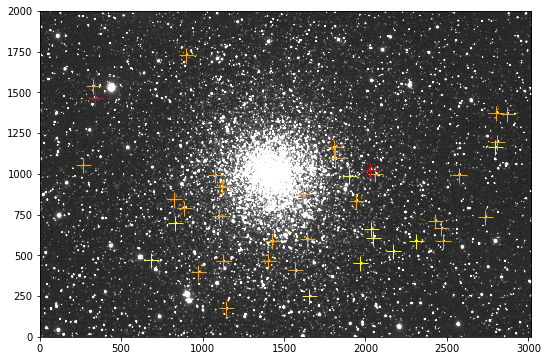

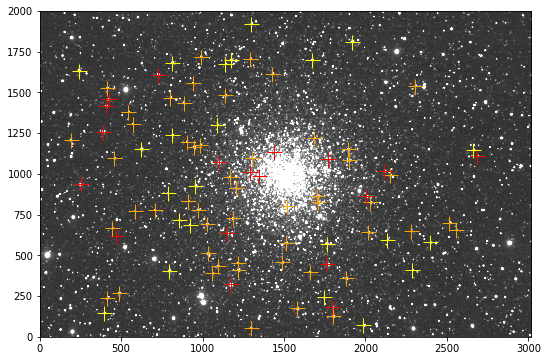

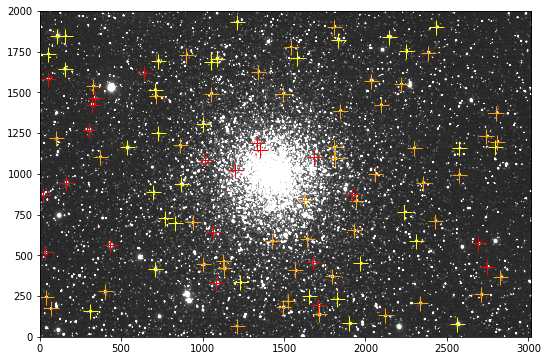

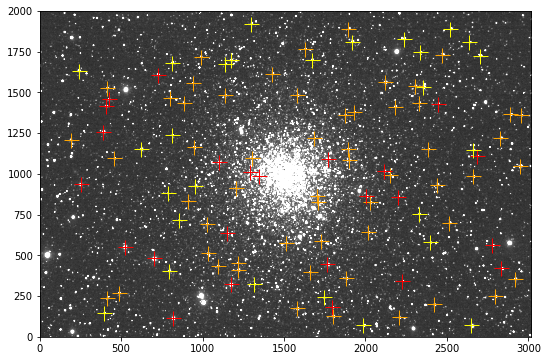

In [5]:
#@title Load data
# Variables that (probably?) won't change for a different cluster target (assuming LCO images):

search_box_deg = 1.5                   # Size of the search *box* (Gaia) or the search *radius* (APASS)
mag_limit = 17                         # Ignore stars fainter than this; LCO 0.4m telescopes cannot detect them reliably.
min_mag_diff, max_mag_diff = 0.1, 0.7  # APASS Vmag - Gaia gmag.  The APASS V filter is narrower than Gaia "gband", so any given star should be slightly dimmer in APASS than Gaia.  
distance_threshhold = 0.0007           # Minimum distance in degrees between star coordinates for it to be possible for them to be the same star.
ref_file_fraction = 0.95               # Minimum fraction of images in which a star must appear to be considered for a ref star.
good_ref_stdev = 0.03                  # Highest acceptable standard deviation for the calibrated magnitude of a ref star.
good_ref_criterion = 5                 # Lowest number of check stars against which the calibrated mag of a ref star must have a stdev lower than good_ref_stdev (criterion is relaxed for dim stars of mag > 15).
default_star_mag = 14.5                # If the magnitude of a target star is unknown (from Gaia / APASS), use a ref star of about this magnitude.

# Variables that are specific to a given target / set of paths:

target, ra_deg, dec_deg = "NGC3201", 154.415222388, -46.4561360212
p = "/content/drive/MyDrive/The Clusterminators/"
img_path = os.path.join(p, 'Images/LCOGTOHSInStAR/2021_Clusters/NGC3201/')
images = {"V": os.path.join(img_path, 'NGC3201_V_2459267d1363186929_2021d02d21T15d08d07d070_1a0551449_300d237_kb24_OHSInStAR.fit'),
          "ip": os.path.join(img_path, 'NGC3201_ip_2459267d2642491790_2021d02d21T18d13d34d684_1a4900727_150d243_kb24_OHSInStAR.fit') }
catalog_urls = {"Terzan3": "http://www.astro.utoronto.ca/~cclement/cat/C1625m352",
                "NGC3201": "http://www.astro.utoronto.ca/~cclement/cat/C1015m461",
                "M92": "http://www.astro.utoronto.ca/~cclement/cat/C1715p432"       # Must add additional target catalogs manually
                }
phot_file_folder = os.path.join(p, "photometry/Time_Series_Photometry_Files/")  # Folder where the json dictionaries should be stored and also where 
                                                                                # raw phot files are organized into folders named as str(target+"_"+phot+"_"+filt).

phot_json_file = os.path.join(phot_file_folder, str(target+"_regions.json"))    # Dictionary for photometry of the stars in the images.
ref_json_file = os.path.join(phot_file_folder, str(target+"_refs.json"))        # Dictionary for reference stars.

# Variables for photometries and filters
phots, filts = ["psx", "sex"], ["V", "ip"] 

if not os.path.isfile(phot_json_file):
  cluster_catalog = retrieve_cluster_catalog(target, catalog_urls[target])   # Gets the Clements Cluster catalog from the webpage
  gstars, epoch = get_gaia_edr3_stars_within_search_box(ra_deg, dec_deg, search_box_deg, mag_limit, target)   # queries Gaia for stars around the region of the target
  Astars, Astar_region = get_APASS_stars_within_search_radius(ra_deg, dec_deg, search_box_deg, mag_limit, "J"+str(epoch), epoch)  # queries APASS catalog 9 for stars around the region of the target
  regions = match_stars(Astars, gstars, distance_threshhold, min_mag_diff, max_mag_diff, cluster_catalog)  # matches stars between Gaia, APASS, and the Clements cluster catalog, and puts it all into one big dictionary

  refs = {}
  for phot in phots:
    for filt in filts:
      raw_phot_folder = os.path.join(phot_file_folder, str(target+"_"+phot+"_"+filt))
      star_counts, num_files = id_stars(raw_phot_folder, regions, distance_threshhold, phot, filt)  # matches stars in the phot files to the three catalogs
      good_refs = id_ref_stars(star_counts, regions, num_files, ref_file_fraction, phot, filt, good_ref_stdev, good_ref_criterion)  # finds good ref stars within the series
      refs[phot+"."+filt] = good_refs
      calibrate(regions, phot, filt, good_refs, default_star_mag)  # calibrates each star in the phot files using the closest magnitude ref star
  store_data_as_json(regions, refs, phot_json_file, ref_json_file)

regions, refs = read_data_from_json(phot_json_file, ref_json_file)

for photfilt in refs.keys():
  good_refs = refs[photfilt]
  m = re.search(r"^(\w\w\w)\.(\w+)$", photfilt)
  phot, filt = m.group(1), m.group(2)
  image = images[filt]
  show_best_ref_stars(good_refs, image, phot, filt)

In [ ]:
#@title Make Lightcurves
def bokeh_lightcurve_plot (phases, diff_mags, tit, subtit, color1, color2):
  bp = bk.figure(
    plot_width=250, plot_height=250,
#    x_axis_label = "Phase", y_axis_label = "Differential Magnitude"
  )

  second_period = []
  for p in phases:
    second_period.append(p+1)

  bp.line(phases, diff_mags, color="pink")
  bp.scatter(phases, diff_mags, size=4, color=color1)

  bp.line(second_period, diff_mags, color="pink")
  bp.scatter(second_period, diff_mags, size=3, color=color2)

#  bp.xaxis.axis_label_text_font_size = "12pt"
#  bp.yaxis.axis_label_text_font_size = "12pt"
  bp.y_range.flipped = True    # Flip the vertical axis so that the dim part goes at the bottom.

#  bp.add_layout(Title(text=subtit, text_font_style="italic"), 'above')
  bp.add_layout(Title(text=tit, text_font_size="9pt"), 'above')
  
  return(bp)

##########################################

def bokeh_string_length_plot (periods, lengths, tit, subtit, filt):
  bp = bk.figure(
    plot_width=200, plot_height=200,
    x_axis_label = "Period Guess", y_axis_label = "String Length", 
  )

  color="slateblue"
  if filt == "V":
    color="blueviolet"

  bp.line(periods, lengths, color=color)
  bp.title.text_font_size = '12pt'
  bp.xaxis.axis_label_text_font_size = "12pt"
  bp.yaxis.axis_label_text_font_size = "12pt"
  # plot.y_range.flipped = True    # If you flip the y axis, then you want the maximum value 
                                   # rather than the minimum, and it is called a "power spectrum"
                                   # (don't ask me why.  Some people prefer for "maximum" to mean "best".).
                                   # I'm just putting this code here so it will be easy to flip if a
                                   # reviewer asks us to.

  bp.add_layout(Title(text=subtit, text_font_style="italic"), 'above')
  bp.add_layout(Title(text=tit, text_font_size="12pt"), 'above')
  return(bp)

##########################################

def clean_and_plot(phases, mags, plot_title, plot_subtitle, n, filt):

  cleaned_mags, cleaned_phases = [], []   # Remove points that are more than 3 stdevs from 
  l = len(phases)                         # the average of the n adjacent points on either side.

  for i in range(l):
    adj = []
    if i < n:
      adj = mags[(i-n):] + mags[0:(i+n+1)]
    elif i+n >= l:
      adj = mags[(i-n):l] + mags[0:(n-l+i+1)]
    else:
      adj = mags[(i-n):(i+n+1)]

    adjacent_points_avg, adjacent_points_stdev = np.mean(adj), np.std(adj)
    if abs(mags[i] - adjacent_points_avg) < (3*adjacent_points_stdev):   
      cleaned_mags.append(mags[i])
      cleaned_phases.append(phases[i])

  color1, color2 = "blue", "red"
  if filt == "ip":
    color1, color2 = "darkblue", "maroon"

  bp = bokeh_lightcurve_plot (cleaned_phases, cleaned_mags, plot_title, plot_subtitle, color1, color2)

  return(bp)

##########################################

def fold(ts, mags, period):
  phases = []
  for i in range(len(ts)):
    t, mag = ts[i], mags[i]
    phase = (((ts[i] - ts[0])/period)%1)
    phases.append(phase)

  sorted_phases, sorted_mags = [], []
  phase_indices = np.asarray(phases).argsort()
  for i in range(0,len(phases)):
    sorted_phases.append(phases[phase_indices[i]])
    sorted_mags.append(mags[phase_indices[i]])

  string_length = 0.0
  for i in range(len(sorted_phases)):
    phase, mag = sorted_phases[i], sorted_mags[i]
    if i >= 1:
      last_phase, last_mag = sorted_phases[i-1], sorted_mags[i-1]
      segment = np.sqrt(((phase - last_phase)**2) + ((mag - last_mag)**2))
      string_length += segment    

  return(sorted_phases, sorted_mags, string_length)

##########################################

def period_finder(raw_ts, raw_mags, test_periods):
  string_lengths, lowest_string_length, best_period, best_phases, best_mags = [], 10000000000000.0, 0.0, [], []

  for test_period in test_periods:
    phases, mags, string_length = fold(raw_ts, raw_mags, test_period)
    string_lengths.append(string_length)
    if string_length < lowest_string_length:
      lowest_string_length = string_length
      best_period = test_period
      best_phases = phases
      best_mags = mags

  best_period = round(best_period,4)
  return(string_lengths, best_period, best_phases, best_mags, lowest_string_length)


##########################################

# The default is to search for RR Lyraes, which typically have periods between 0.2 and 1 day.
# However, the Clements cluster catalog lists some other types of variables: notably SXP 
# (which have much shorter periods), and a few EB's, which have longer periods, and even
# a couple of longer-period variables (e.g. Mira-type variables).  If the type is known,
# then constrain the code to search for periods in the correct range.  Otherwise, default
# to the RR Lyrae period range.

def get_test_periods(min_period, max_period, period_increment, lit_period, typ):
  mi, ma, pi = min_period, max_period, period_increment

  if type(lit_period) is float and lit_period > 0 and (not re.search(r"^RR", typ)):
    mi = lit_period - 0.2
    ma = lit_period + 0.2
    if mi < 0.01:
      mi = 0.01

  num_periods = int((ma - mi)/pi)
  test_periods = []
  for i in range(num_periods):
    test_period = (mi + (i*pi))
    test_periods.append(test_period)

  return(test_periods)

##########################################

def do_one_star(phot, filt, star, ra, dec, ts, mags, num_adjacent_points, mag_limit, amp_limit, min_period, max_period, period_increment, name_dict):
  plots, lit_period, typ = [], float('nan'), ""
  ra, dec = round(float(ra),5), round(float(dec),5)
  if star["is_known_pulsator"]:
    d = star["stardata"]["Clements"]
    num, typ, lit_period, cmag, amp = d['num'], d['typ'], d['period'], d['mag'], d['amp']
    plot_subtitle = str(f"{typ} {cmag} {amp} ({round(float(ra),5)}, {round(float(dec),5)}) {lit_period}")
    star_name = str(f"NGC 3201 V{num}")
    if num in name_dict:
      star_name = name_dict[num]

    if (typ == "CST" or (type(lit_period) is float and lit_period > 5)):    # We cannot reliably detect periods longer than 2 days.
      return("none", "none")
    if type(cmag) is float and cmag > mag_limit:  # This magnitude is too dim to capture with the LCO 0.4m telescopes.
      return("none", "none")
    if type(amp) is float and amp < amp_limit:  # We cannot confirm pulsation with amplitude less than 0.2.
      return("none", "none")

    if type(lit_period) is float and lit_period > 0:
      lit_phases, lit_mags, lit_string_length = fold(ts, mags, lit_period)
      lit_plot_title = str(f"LIT {phot} {filt} {typ} p={lit_period} l={round(lit_string_length,2)}")
      plots.append(clean_and_plot(lit_phases, lit_mags, lit_plot_title, plot_subtitle, num_adjacent_points, filt))

  test_periods = get_test_periods(min_period, max_period, period_increment, lit_period, typ)
  string_lengths, best_period, best_phases, best_mags, lowest_string_length = period_finder(ts, mags, test_periods)
  genie_plot_title = str(f"{star_name}")
  titles = {"t": genie_plot_title, "s": plot_subtitle, "p": best_period }
  print(f"{genie_plot_title},{round(float(ra),5)}, {round(float(dec),5)},{typ},{cmag},{amp},{lit_period},{best_period},{phot},{filt}")
  plots.append(clean_and_plot(best_phases, best_mags, genie_plot_title, plot_subtitle, num_adjacent_points, filt))
  plots.append(bokeh_string_length_plot(test_periods, string_lengths, genie_plot_title, plot_subtitle, filt))
  return(plots, titles)

################################################################################

def find_variables(regions, phots, filts, num_adjacent_points, mag_limit, amp_limit, min_period, max_period, period_increment, name_dict):
  V_plots, V_titles, filter_plots = [], [], []
  bk.output_notebook()
  star_num = 0
  for region in regions:
    stars = regions[region]
    for id in stars.keys():
      ra, dec = id.split(",")
      star = stars[id]
      if not star["is_known_pulsator"]:  # Doing all of the stars would take too much processing time.
        continue

      star_num += 1
      for filt in filts:
        filt_plots = []
        for phot in phots:
          if phot+filt not in star["phot"]:  # star did not appear in our images
            continue
          if star["phot"][phot+filt]["image_count"] < 50:  # star appeared in less than 50 of our images
            continue

          timeseries = star["phot"][phot+filt]["timeseries"]
          ts, mags = [], []
          for t in sorted(timeseries.keys()):
            if "mag" in timeseries[t].keys():
              ts.append(float(t))
              mags.append(timeseries[t]["mag"])
          plots, titles = do_one_star(phot, filt, star, ra, dec, ts, mags, num_adjacent_points, mag_limit, amp_limit, min_period, max_period, period_increment, name_dict)            
          if plots =="none" or len(plots)==0:
            continue
          if (filt == "V" and phot=="psx" and len(plots)==3 and re.search(r"^RR", star["stardata"]["Clements"]["typ"])):
            V_plots.append(plots[1])
            V_titles.append(titles)
            # bk.show(plots[1])
          if len(filt_plots) == 0:      # Only include the literature plot once, at the beginning of a row.
            filt_plots.append(plots[0])
          for i in range(1,len(plots)):
            filt_plots.append(plots[i])
      filter_plots.append(filt_plots)
#      print(f"star num {star_num} done")
  return(V_plots, V_titles, filter_plots)

##########################################

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

num_adjacent_points = 10               # Number of points to be used on either side of a star in phase in screening for outliers (reject points more than 3 stdevs from the average of these).
amp_limit = 0.2                        # Minimum amplitude pulsation we can expect to be able to confirm (at least 6x the minimum stdev of a ref star's maximum variability).
min_period = 0.2                       # Minimum pulsator period in days, defaults to RR Lyrae period range
max_period = 1.0                       # Maximum pulsator period in days, defaults to RR Lyrae period range           
period_increment = 0.0001              # Resolution of the search for an appropriate period

V_plots, V_titles, filter_plots = find_variables(regions, phots, filts, num_adjacent_points, mag_limit, amp_limit, min_period, max_period, period_increment, name_dict)

plots_per_row = 4
V_rows = []
V_row = []
num_in_row = 0
for plot in V_plots:
  num_in_row += 1
  V_row.append(plot)
  if num_in_row >= plots_per_row:
    V_rows.append(V_row)
    V_row = []
    num_in_row = 0

for t in V_titles:
  print(t)
grid = gridplot(V_rows)
bk.show(grid)


<IPython.core.display.Javascript object>

NGC 3201 V78,154.40374, -46.45109,RR0,14.85,1.0,0.5139,0.5137,psx,V
NGC 3201 V78,154.40374, -46.45109,RR0,14.85,1.0,0.5139,0.5135,sex,V
NGC 3201 V78,154.40374, -46.45109,RR0,14.85,1.0,0.5139,0.514,psx,ip
NGC 3201 V78,154.40374, -46.45109,RR0,14.85,1.0,0.5139,0.5136,sex,ip
NGC 3201 V7,154.36872, -46.46352,RR0,14.69,0.67,0.6303,0.6301,psx,V
NGC 3201 V7,154.36872, -46.46352,RR0,14.69,0.67,0.6303,0.6306,sex,V
NGC 3201 V7,154.36872, -46.46352,RR0,14.69,0.67,0.6303,0.6283,psx,ip
NGC 3201 V7,154.36872, -46.46352,RR0,14.69,0.67,0.6303,0.6304,sex,ip
ASASSN-V J101726.09-462702.3,154.35875, -46.45063,RR0,14.74,0.9,0.5253,0.5263,psx,V
ASASSN-V J101726.09-462702.3,154.35875, -46.45063,RR0,14.74,0.9,0.5253,0.5265,sex,V
ASASSN-V J101726.09-462702.3,154.35875, -46.45063,RR0,14.74,0.9,0.5253,0.5265,psx,ip
ASASSN-V J101726.09-462702.3,154.35875, -46.45063,RR0,14.74,0.9,0.5253,0.5265,sex,ip
ASASSN-V J101742.79-463001.0,154.42842, -46.50035,RR0,14.76,1.21,0.4843,0.4843,psx,V
ASASSN-V J101742.79-463001.0,1

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
bk.show(grid)

<IPython.core.display.Javascript object>

In [ ]:
#@title Show particular target stars
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
import os
import csv
import urllib.request
import urllib.parse
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
import numpy as np

##############################################################
def show_stars (InputFITS, target_stars):
  infits = fits.open(InputFITS)

  wrld = WCS(infits[0].header)
  fdims = wrld.pixel_shape
  xcenterpix, ycenterpix = fdims[0]/2, fdims[1]/2
  centercoords = wrld.pixel_to_world(xcenterpix,ycenterpix)
  centerRA, centerDec = centercoords.ra.degree, centercoords.dec.degree

  image_data = infits[0].data
  norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111)
  plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)
  for i in range(len(target_stars)):
    star = target_stars[i]
    label, color = "", ""
    if i < 3:
#      label = str(f"Fig {i+3}")
      label = "RR0"
      color="red"
    if i == 3:
#      label = "Fig 6"
      label = "RR1"
      color="red"
    if i == 4:
#      label = "Fig 7"
      label = "RR2"
      color="red"
    if i == 5:
      label = "SXP"
      color="lime"
    ra, dec = star["ra"], star["dec"]
    skystar = SkyCoord(ra, dec, frame='fk5', unit='deg')
    stary, starx = wrld.world_to_array_index(skystar)

    ax.plot(starx, stary, marker='+',color=color, ms=20)
    ax.text((starx+10), (stary+1), label, color=color, fontsize=15, fontweight='bold')

##############################################################
p = "/content/drive/MyDrive/The Clusterminators/"
img_path = os.path.join(p, 'Images/LCOGTOHSInStAR/2021_Clusters/NGC3201/')
images = {"V": os.path.join(img_path, 'NGC3201_V_2459267d1363186929_2021d02d21T15d08d07d070_1a0551449_300d237_kb24_OHSInStAR.fit'),
          "ip": os.path.join(img_path, 'NGC3201_ip_2459267d2642491790_2021d02d21T18d13d34d684_1a4900727_150d243_kb24_OHSInStAR.fit') }
target_stars = [{"ra": 154.3587, "dec": -46.4506}, {"ra": 154.3627, "dec":-46.4146 }, {"ra": 154.3846, "dec": -46.4368 }, {"ra": 154.4096, "dec": -46.6328 }, {"ra": 154.2463, "dec": -46.3301}, {"ra": 154.4508, "dec": -46.4316 }]
InputFits = images["V"]
show_stars(InputFits, target_stars)


In [ ]:
#@title Get data for other clusters (independent of main script)
#################################################

def cluster_catalog_RAs(url):
  print(f"Getting data from Clements cluster catalog.")
  cat = requests.get(url)
  content = cat.content.decode("utf-8").split("\n")
  for l in content:
    m = re.search(r"href=\"(http\:\/\/www\.astro\.utoronto\.ca\/\~cclement\/cat\/\w+)\"\>([^\<]+)\<\/a\>",l)
    if m:
      cluster_pulsator_list(m.group(1), m.group(2))

#################################################

def cluster_pulsator_list(cluster_url, target_name):
  cat = requests.get(cluster_url)
  content = cat.content.decode("utf-8").split("\n")

  cluster, num_pulsators, num_RR_Lyrae, num_student_compatible_RR_Lyrae, RA, DEC, RA_DEG, DEC_DEG = [], 0, 0, 0, "", "", 0.0, 0.0
  for l in content:
    m = re.search("RA\:\s+(\d\d?\:\d\d\:\d\d\.?\d*)\s+D?E?C?\:?\s*([+-]?\d\d?\:\d\d\:\d\d\.?\d*)", l)
    if m:
      RA, DEC = m.group(1), m.group(2)
      c = SkyCoord(RA, DEC, unit=(u.hourangle, u.deg))
      RA_DEG, DEC_DEG = float(c.ra.deg), float(c.dec.deg)
      continue
    if len(l) > 60:
      if re.search(r"\d\d?\:\d\d\:\d\d\.?\d*", l[8:20]) and re.search(r"\d\d?[\:\s]\d\d[\:\s]\d\d\.?\d*", l[21:33]):
        cluster_num = l[0:9]
        m = re.search(r"^([\d\s]+)$", cluster_num)
        if m:
          cluster_num = int(l[0:3])
        num_pulsators += 1
        ra_hms = l[8:20].strip()
        dec_dms = l[21:33].strip()
        ra_hms = ra_hms.replace("R","")
        dec_dms = dec_dms.replace("R","")
        m = re.search(r"(\d\d\:\d\d\:\d\d)\:(\d+)", ra_hms)
        if m:
          ra_hms = m.group(1)+"."+m.group(2)
        m = re.search(r"([+-]?\d\d\:\d\d\:\d\d)\:(\d+)", dec_dms)
        if m:
          dec_dms = m.group(1)+"."+m.group(2)
        period = l[36:44]
        if not re.search(r"\d+", period):
          period = "-"
        if not re.search(r"-", period):
          period = float(period)
        mag = l[45:51]
        if not re.search(r"\d+", mag):
          mag = "-"
        if not re.search(r"-", mag):
          mag = mag.replace("l","1")
#          print(f"mag {mag}")
          mag = round(float(mag),2)
          if mag > 17.5:
            continue
        amp = l[52:58]
        if not re.search(r"\d+", amp):
          amp = "-"
        if re.search(r"^[\d\s\.]+$", amp):
          amp = round(float(amp),2)
        typ = l[60:63]
        m = re.search("RR[012]", typ)
        if m:
          num_RR_Lyrae += 1
          if type(mag) is float and mag < 17.5 and type(amp) is float and amp > 0.2 and type(period) is float and period < 8:
            num_student_compatible_RR_Lyrae += 1
        c = SkyCoord(ra_hms, dec_dms, unit=(u.hourangle, u.deg))
        ra, dec = float(c.ra.deg), float(c.dec.deg)
        ident = str("%.6f,%.6f" % (ra, dec))
        k = str(f"%.1f,%.1f" % (ra, dec))
#        print(f"%.5f %.5f %s {amp} {mag}" % (ra, dec, typ))

        cluster.append ({ "num": cluster_num, "id": ident, "ra": ra, "dec": dec, "period": period, "mag": mag, "amp": amp, "typ": typ })

  num_pulse = len(cluster)
  print(f"{target_name},'{RA},'{DEC},{round(RA_DEG, 3)},{round(DEC_DEG,3)},{num_pulsators},{num_RR_Lyrae},{num_student_compatible_RR_Lyrae},{cluster_url}")
  return(cluster)

#################################################

import requests
url = "http://www.astro.utoronto.ca/~cclement/cat/listngc.html"
cluster_catalog_RAs(url) 

Getting data from Clements cluster catalog.
N104 (47 Tuc),'00:24:05.67,'-72:04:52.6,6.024,-72.081,283,2,2,http://www.astro.utoronto.ca/~cclement/cat/C0021m723
N288,'00:52:45.24,'-26:34:57.4,13.188,-26.583,10,2,2,http://www.astro.utoronto.ca/~cclement/cat/C0050m268
N362,'01:03:14.26,'-70:50:55.6,15.809,-70.849,77,29,23,http://www.astro.utoronto.ca/~cclement/cat/C0100m711
N1261,'03:12:16.21,'-55:12:58.4,48.068,-55.216,9,4,0,http://www.astro.utoronto.ca/~cclement/cat/C0310m554
Pal 1,'03:33:20.04,'+79:34:51.8,53.333,79.581,0,0,0,http://www.astro.utoronto.ca/~cclement/cat/C0325p794
AM 1,'03:55:02.3,'-49:36:55,58.76,-49.615,0,0,0,http://www.astro.utoronto.ca/~cclement/cat/C0354m498
Eridanus,'04:24:44.5,'-21:11:13,66.185,-21.187,0,0,0,http://www.astro.utoronto.ca/~cclement/cat/C0422m213
Pal 2,'04:46:05.91,'+31:22:53.4,71.525,31.381,0,0,0,http://www.astro.utoronto.ca/~cclement/cat/C0443p313
N1851,'05:14:06.76,'-40:02:47.6,78.528,-40.047,51,42,28,http://www.astro.utoronto.ca/~cclement/cat/C0512

In [ ]:
def make_table(p):
  with open(p, "r") as data:
    star_dict = {}
    for index, line in enumerate(data):
      name, ra, dec, typ, mag, amp, lit_period, best_period, phot, filt = line.strip().split(",")
      ra = float(ra)
      dec = float(dec)
      m = re.search(r"\d", mag)
      if m:
        mag = float(mag)
      m = re.search(r"\d", amp)
      if m:
        amp = float(amp)
      key = str(f"{name},{ra},{dec},{mag},{amp},{lit_period}")
      if key not in star_dict:
        star_dict[key] = {}
      star_dict[key][phot+filt] = best_period
  for star in star_dict:
    print(star)
    print(star_dict[star])
    psxV = star_dict[star]["psxV"]
    psxip = star_dict[star]["psxip"]
    sexV = star_dict[star]["sexV"]
    sexip = star_dict[star]["sexip"]
    print(f"{key},{psxV},{psxip},{sexV},{sexip}")





p = "/content/drive/MyDrive/The Clusterminators/Code/Kalee/periods.csv"
make_table(p)


﻿NGC 3201 V78,154.40374,-46.45109,14.85,1.0,0.5139
{'psxV': '0.5137'}


KeyError: ignored

In [8]:
refs = [(154.213977, -46.367741), (154.231096, -46.449069), (154.266514, -46.34078),
        (154.266917, -46.435484), (154.276777, -46.498893), (154.281069, -46.409154),
        (154.280761, -46.365305), (154.282767, -46.295013), (154.292738, -46.530938),
        (154.307891, -46.579365), (154.30803, -46.552975), (154.308686, -46.41207), 
        (154.311382, -46.44671), (154.312795, -46.511415), (154.325056, -46.509633), 
        (154.325948, -46.578203), (154.335154, -46.318699), (154.336086, -46.571854), 
        (154.340892, -46.620709), (154.343989, -46.3609), (154.356665, -46.326914), 
        (154.365238, -46.495362), (154.368497, -46.317288), (154.375582, -46.443037), 
        (154.386264, -46.364043), (154.399782, -46.488708), (154.401407, -46.595251), 
        (154.402265, -46.357666), (154.403205, -46.51473), (154.408957, -46.509522), 
        (154.416766, -46.22887), (154.42554, -46.474459), (154.439902, -46.631102), 
        (154.440574, -46.473334), (154.447799, -46.632427), (154.487884, -46.642223), 
        (154.489238, -46.631927), (154.512328, -46.240587), (154.528171, -46.239067), 
        (154.572691, -46.330556)]

AAVSO_refs = [(154.17329, -46.49244), (154.18971, -46.59292), (154.28625, -46.55450),
(154.29900, -46.59750), (154.31262, -46.51139), (154.33983, -46.54222), (154.40138, -46.59531), (154.57425, -46.56581)]

for r in AAVSO_refs:
  ra, dec = r[0], r[1]
  for ref in refs:
    rra, rdec = ref[0], ref[1]
    ra_diff, dec_diff = abs(ra - rra), abs(dec - rdec)
    if ra_diff < 0.009 and dec_diff < 0.009:
      print(f"AAVSO {ra} {dec} ref {rra} {rdec} diff {round(ra_diff*3600,1)}, {round(dec_diff*3600,1)} ")


AAVSO 154.31262 -46.51139 ref 154.312795 -46.511415 diff 0.6, 0.1 
AAVSO 154.40138 -46.59531 ref 154.401407 -46.595251 diff 0.1, 0.2 
